In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [3]:
# !git clone https://github.com/frgfm/torch-cam.git

Cloning into 'torch-cam'...
remote: Enumerating objects: 6551, done.
remote: Counting objects: 100% (2089/2089), done.
remote: Compressing objects: 100% (762/762), done.
remote: Total 6551 (delta 1474), reused 1872 (delta 1310), pack-reused 4462
Receiving objects: 100% (6551/6551), 9.99 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (4536/4536), done.


In [3]:
from juneja.validation_pipeline.preprocess import img_to_tensor
from juneja.validation_pipeline.metrics import normalize, match_hist, normalize_map, SIM, CC, NSS
from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from shardul.ScoreCAM.utils.visualize import visualize, reverse_normalize
from shardul.ScoreCAM.utils.imagenet_labels import label2idx, idx2label


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


In [4]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

2023-10-25 03:12:10.725314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 03:12:12.069442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/smitra/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/smitra/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-10-25 03:12:12.069591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7

In [5]:
!nvidia-smi

Wed Oct 25 03:12:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 31%   54C    P2              77W / 250W |    807MiB / 11264MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
classes = get_imagenet_classes()

In [7]:
#Load all images
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)

In [8]:
#Load Ground truth saliencies of 20 images
ground_gradcam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAM_20.npy')
ground_scorecam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_ScoreCAM_20.npy')
ground_gradcampp_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAMpp_20.npy')

#Load Ground truth idx of 20 images
ground_gradcam_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAM_20.npy')
ground_scorecam_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_ScoreCAM_20.npy')
ground_gradcampp_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAMpp_20.npy')

In [9]:
#Load perturbed images array which contains array of arrays so at 'i' location of 
#perturbed_images_array we contain all occluded images of 'i' image
perturbed_images_array = np.load('/project/validating_attribution_techniques/shardul/data/occlusion/Images_20.npy')

In [10]:
def preprocessing_array_image(image):
    # Resize the image
    size = (300, 300)
    image = image.astype(np.uint8)
    image = Image.fromarray(image)  # Convert the NumPy array back to an image
    image = image.resize(size)

    # Preprocessing. Mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # Convert image to tensor
    tensor = preprocess(image)

    # Reshape the tensor to 4D (N, C, H, W)
    tensor = tensor.unsqueeze(0)

    return tensor

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_gpu.eval()

Using cache found in /home/smitra/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
target_layer = model_gpu.layer4[1].conv2
classes1 = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

In [13]:
# def scoreCAM(target_layer, model, tensor):
#     wrapped_model = ScoreCAM(model, target_layer)
#     cam, idx = wrapped_model(tensor)
#     return cam, idx
# def gradCAM(target_layer, model, tensor):
#     wrapped_model = GradCAM(model, target_layer)
#     cam, idx = wrapped_model(tensor)
#     return cam, idx
# def gradpp(target_layer, model, tensor):
#     # Create an instance of SmoothGradCAMpp
#     wrapped_model = GradCAMpp(model, target_layer)
#     # Call GradCAMpp without the tensor argument
#     cam, idx = wrapped_model(tensor)
    
#     return cam, idx
resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

scorecam_wrapped_model = ScoreCAM(model_gpu, target_layer)
gradcam_wrapped_model = GradCAM(model_gpu, target_layer)
smoothgradcampp_wrapped_model = SmoothGradCAMpp(model_gpu, target_layer, n_samples=25, stdev_spread=0.15)

In [14]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [15]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [16]:
def wasserstein_distance(cam, perturbed_cam, method):
    # Ensure that the tensors have the same shape
    if method == "GradCAM":
        emd = EMD(np.reshape(cam.numpy(),(10,10)), np.reshape(perturbed_cam.numpy(),(10,10)), 1)
        return emd[0]
    elif method == "ScoreCAM":
        emd = EMD(np.reshape(cam.numpy(),(300,300)), np.reshape(perturbed_cam.numpy(),(300,300)), 1)
        return emd[0]
    elif method == "GradCAMpp":
        cam = np.where(cam > 0, cam, 1e-5)
        perturbed_cam = np.where(perturbed_cam > 0, perturbed_cam, 1e-5)
        emd = EMD(np.reshape(cam, (10, 10)), np.reshape(perturbed_cam, (10, 10)), 1)
        return emd[0]
def calculate_metrics(cam, perturbed_cam, method):
    sim = SIM(cam, perturbed_cam)
    cc = CC(cam, perturbed_cam)
    nss = NSS(cam, perturbed_cam)
#     auc_judd = AUC_Judd(cam, perturbed_cam)
#     auc_borji = AUC_Borji(cam, perturbed_cam)
#     emd = wasserstein_distance(cam, perturbed_cam, method)
    return sim, cc, nss

In [17]:
#Done indexes: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
img_idx = 1 #Yet to start

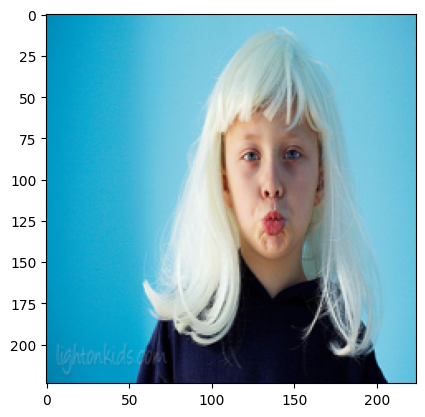

In [18]:
imshow(Image.fromarray((images[img_idx])))
# imshow(original_image)

In [24]:
original_image = Image.fromarray((images[img_idx]).astype(np.uint8))
input_tensor = resnet_transform(original_image).unsqueeze(0).to(device)

In [25]:
scorecam_mask, scorecam_idx, scorecam_probs = scorecam_wrapped_model(input_tensor)
scorecam_mask =  scorecam_mask.cpu().numpy().squeeze()
scorecam_probs = scorecam_probs.cpu().numpy()

gradcam_mask, gradcam_idx, gradcam_probs = gradcam_wrapped_model(input_tensor)
gradcam_mask =  gradcam_mask.cpu().numpy().squeeze()
# gradcam_probs = gradcam_probs.cpu().numpy()

predicted class ids 903	 probability 0.9223191738128662


In [26]:
smoothgradcam_mask, smoothgradcam_idx = smoothgradcampp_wrapped_model(input_tensor)
smoothgradcam_mask =  smoothgradcam_mask.cpu().numpy().squeeze()

predicted class ids 903	 probability 0.8648753762245178


In [27]:
print(type(scorecam_mask))

<class 'numpy.ndarray'>


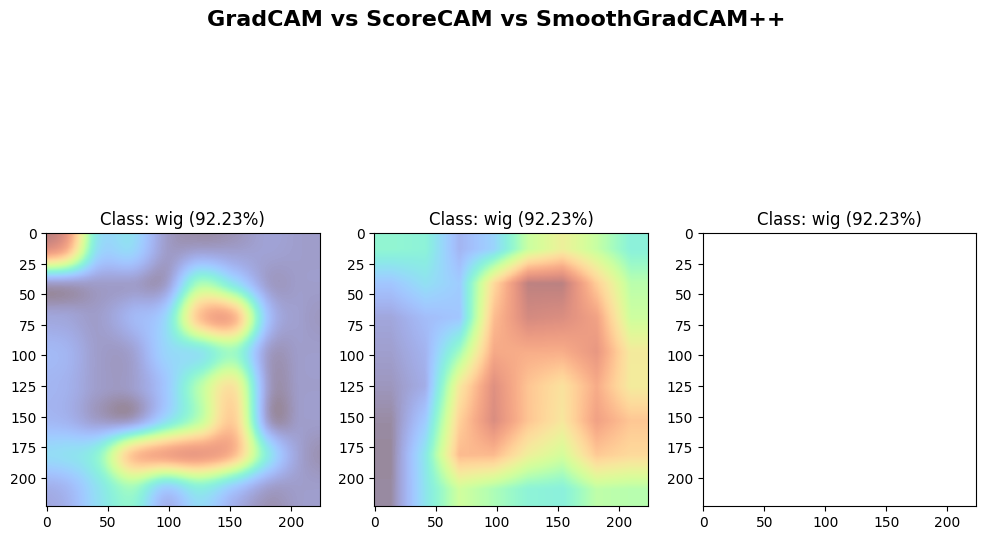

In [28]:

fig, axes = plt.subplots(ncols=3, nrows=1)

fig.set_figwidth(12)
# fig.set_layout_engine('tight')
fig.suptitle("GradCAM vs ScoreCAM vs SmoothGradCAM++", fontsize=16, fontweight="bold",y=0.54)
fig.set_figheight(80)
visualize_saliency_overlay(axes[0], Image.fromarray((images[img_idx])), gradcam_mask, gradcam_probs, gradcam_idx, classes);
visualize_saliency_overlay(axes[1], Image.fromarray((images[img_idx])), scorecam_mask, scorecam_probs, scorecam_idx, classes);
visualize_saliency_overlay(axes[2], Image.fromarray((images[img_idx])), smoothgradcam_mask, scorecam_probs, smoothgradcam_idx, classes);
# fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Images/Img_{img_idx}/Ground_truth_{img_idx}.png")

In [48]:
# img_idx = 0
patch_size = 100

In [49]:
gen_occlu_images = generate_img_occlusion_list_no_saliency(images[img_idx], patch_size)
np.save(f"/project/validating_attribution_techniques/shardul/data/Images/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy", gen_occlu_images)

predicted class ids 903	 probability 0.8384159207344055
predicted class ids 903	 probability 0.43696823716163635
predicted class ids 903	 probability 0.9212607741355896
predicted class ids 903	 probability 0.4566252529621124
predicted class ids 669	 probability 0.49078017473220825
predicted class ids 903	 probability 0.9345401525497437
predicted class ids 903	 probability 0.9100162386894226
predicted class ids 903	 probability 0.8985047936439514
predicted class ids 903	 probability 0.943020224571228


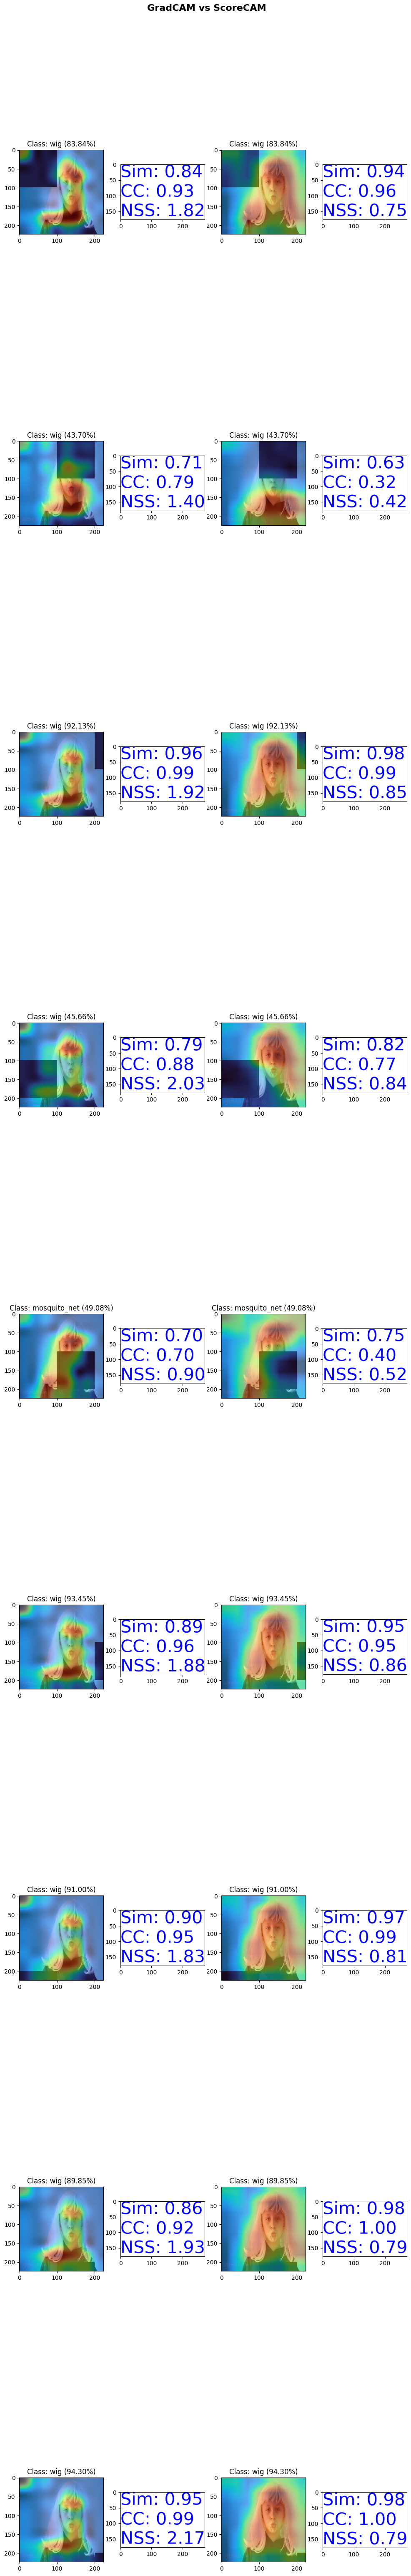

In [50]:

# img_idx = 0
patch_size = 100
ior_values = np.array([])
sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Images/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
rows = len(sample_occlu_imgs)
# print(rows)
fig, axis = plt.subplots(ncols=4, nrows=rows)

fig.set_figheight(80)
fig.set_figwidth(12)

# vit_probs, vit_idx, (vit_cls_mask, vit_distill_mask) = vit_saliency_map(Image.fromarray(images[img_idx]), vit_model)
for row in range(axis.shape[0]):
    idx = row
    img = Image.fromarray((sample_occlu_imgs[idx] * 255).astype(np.uint8))
    occlu_input_tensor = resnet_transform(img).unsqueeze(0).to(device)
    
    
    occlu_gradcam_mask, occlu_gradcam_idx, occlu_gradcam_probs = gradcam_wrapped_model(occlu_input_tensor)
    occlu_gradcam_mask =  occlu_gradcam_mask.cpu().numpy().squeeze()
    
    visualize_saliency_overlay(axis[row, 0], img, occlu_gradcam_mask, occlu_gradcam_probs, occlu_gradcam_idx, classes);
    
    occlu_scorecam_mask, occlu_scorecam_idx, occlu_scorecam_probs = scorecam_wrapped_model(occlu_input_tensor)
    occlu_scorecam_mask =  occlu_scorecam_mask.cpu().numpy().squeeze()
    occlu_scorecam_probs = occlu_scorecam_probs.cpu().numpy()
    
    visualize_saliency_overlay(axis[row, 2], img, occlu_scorecam_mask, occlu_scorecam_probs, occlu_scorecam_idx, classes);
    
    
    sim_grad, cc_grad, nss_grad = calculate_metrics(gradcam_mask, occlu_gradcam_mask, "GradCAM")
    sim_score, cc_score, nss_score = calculate_metrics(scorecam_mask, occlu_scorecam_mask, "ScoreCAM")
    
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}"
    
#     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
    axis[row, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=20, dpi=200))
    
    text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}"
    # Add text for ScoreCAM metrics
    axis[row, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=20, dpi=200))
fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
# fig.show()
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Images/Img_{img_idx}/Occlusion_{patch_size}_{img_idx}.png")

# Store saliencies for occluded images

In [41]:
# #Done Generating saliencies for Images: 
# # Choose the index of the original image you want to work with
# original_image_index = 0  # Change this index as needed

# # Access all the perturbed images for the chosen original image
# perturbed_sub_images = perturbed_images_array[original_image_index]


# gradcam_saliencies = []
# scorecam_saliencies = []
# gradcampp_saliencies = []

# gradcam_idx = []
# scorecam_idx = []
# gradcampp_idx = []

# gradcam_tensors = []
# scorecam_tensors = []
# gradcampp_tensors = []

# heatmaps_grad = []
# heatmaps_score = []

In [27]:


# for i in range(len(perturbed_sub_images)):
#     # Create a new figure for each iteration

# #     # Load the image using PIL
# #     img_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg"
# #     img = Image.open(img_path)
#     perturbed_tensor_grad = preprocessing_array_image(perturbed_sub_images[i])  # calling the preprocessing function
#     perturbed_tensor_score = preprocessing_array_image(perturbed_sub_images[i])  # calling the preprocessing function
#     perturbed_tensor_gradpp = preprocessing_array_image(perturbed_sub_images[i])

#     gpu_reference_tensor = next(model_gpu.parameters())
#     perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
#     perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)
#     perturbed_tensor_gradpp = perturbed_tensor_gradpp.type_as(gpu_reference_tensor)

#     perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer, model_gpu, perturbed_tensor_grad)
#     perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer, model_gpu, perturbed_tensor_score)
#     perturbed_gradcampp, perturbed_gradpp_idx = gradpp(target_layer, model_gpu, perturbed_tensor_gradpp)

#     perturbed_gradcam = perturbed_gradcam.cpu()
#     perturbed_scorecam = perturbed_scorecam.cpu()
#     perturbed_gradcampp = perturbed_gradcampp.cpu()
    
    
#     heatmap_grad = saliency_map(perturbed_tensor_grad, perturbed_gradcam)
#     heatmap_score = saliency_map(perturbed_tensor_score, perturbed_scorecam)

# #     sim_grad, cc_grad, nss_grad, emd_grad = calculate_metrics(Gradcam, perturbed_gradcam, "GradCAM")
# #     sim_score, cc_score, nss_score, emd_score = calculate_metrics(scorecam, perturbed_scorecam, "ScoreCAM")
# #     sim_gradpp, cc_gradpp, nss_gradpp, emd_gradpp = calculate_metrics(Gradcampp, perturbed_gradcampp, "GradCAMpp")
#     print("Iteration", i, "of /", len(images))
    

    
#     # Append the saliency maps to the respective lists
#     gradcam_saliencies.append(perturbed_gradcam)
#     scorecam_saliencies.append(perturbed_scorecam)
#     gradcampp_saliencies.append(perturbed_gradcampp)
    
#     # Append the idx to the respective lists
#     gradcam_idx.append(perturbed_grad_idx)
#     scorecam_idx.append(perturbed_score_idx)
#     gradcampp_idx.append(perturbed_gradpp_idx)
    
#     gradcam_tensors.append(perturbed_tensor_grad)
#     scorecam_tensors.append(perturbed_tensor_score)
#     gradcampp_tensors.append(perturbed_tensor_gradpp)
    
#     heatmaps_grad.append(heatmap_grad)
#     heatmaps_score.append(heatmap_score)
    
    

In [28]:
# # Convert all elements in the gradcam_saliencies list to NumPy arrays
# gradcam_saliencies = [np.array(arr) for arr in gradcam_saliencies]
# scorecam_saliencies = [np.array(arr) for arr in scorecam_saliencies]
# gradcampp_saliencies = [np.array(arr) for arr in gradcampp_saliencies]

# # Save the arrays to files
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_GradCAM_1.npy', gradcam_saliencies)
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_ScoreCAM_1.npy', scorecam_saliencies)
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_GradCAMpp_1.npy', gradcampp_saliencies)

# #Save Idx
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_idx_GradCAM_1.npy', np.array(gradcam_idx))
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_idx_ScoreCAM_1.npy', np.array(scorecam_idx))
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_GradCAMpp_1.npy', np.array(gradcam_idx))

# heatmaps_grad = [np.array(arr) for arr in heatmaps_grad]
# heatmaps_score = [np.array(arr) for arr in heatmaps_score]
# # Save the arrays to files
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_heatmaps_GradCAM_1.npy', heatmaps_grad)
# np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_heatmpas_ScoreCAM_1.npy', heatmaps_score)
# # #Save tensors
# # np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/tensors/Occluded_tensors_GradCAM_20.npy', np.array(gradcam_tensors))
# # np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/tensors/Occluded_tensors_ScoreCAM_20.npy', np.array(scorecam_tensors))
# # np.save('/project/validating_attribution_techniques/shardul/data/Images/Img_1/tensors/Occluded_tensors_GradCAMpp_20.npy', np.array(gradcam_tensors))

In [29]:

# occluded_gradcam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_GradCAM_1.npy')
# occluded_scorecam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_ScoreCAM_1.npy')
# occluded_gradcampp_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_saliencies_GradCAMpp_1.npy')


# occluded_gradcam_idx = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_idx_GradCAM_1.npy')
# occluded_scorecam_idx = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_idx_ScoreCAM_1.npy')
# occluded_gradcampp_idx = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/idx/Occluded_GradCAMpp_1.npy')

# heatmaps_grad = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_heatmaps_GradCAM_1.npy')
# heatmaps_score = np.load('/project/validating_attribution_techniques/shardul/data/Images/Img_1/saliency/Occluded_heatmpas_ScoreCAM_1.npy')


In [30]:
# visualize_saliency_overlay(plt.gca(), Image.fromarray((perturbed_sub_images[1]*255).astype(np.uint8)), occluded_scorecam_saliencies[6].squeeze());
# # occluded_scorecam_saliencies[0].squeeze().shape